> If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor

> A group of pre dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method

# Voting Classifier

Suppose you have trained a few classifiers, each one achieving about 80% accuracy. You may have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighbors classifier, and perhaps a few more (see Figure 7-1)

<p align='center'>
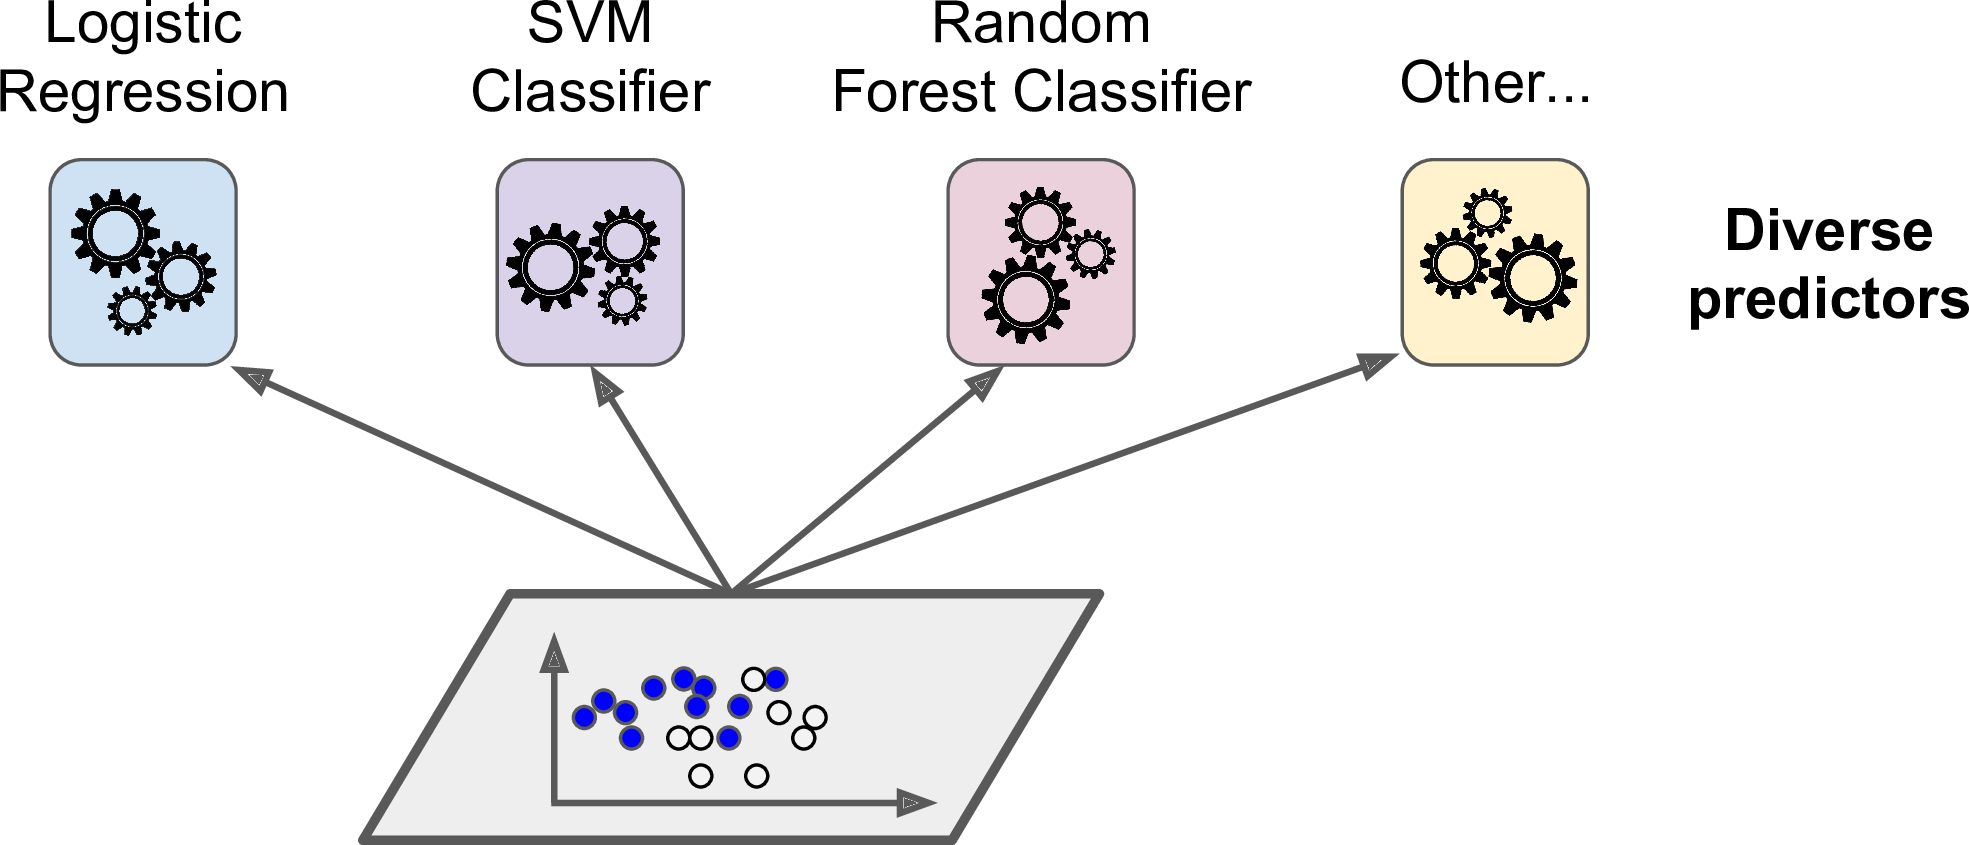
</p>
Figure 7-1. Training diverse classifier

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier (see Figure 7-2)

<p align='center'>
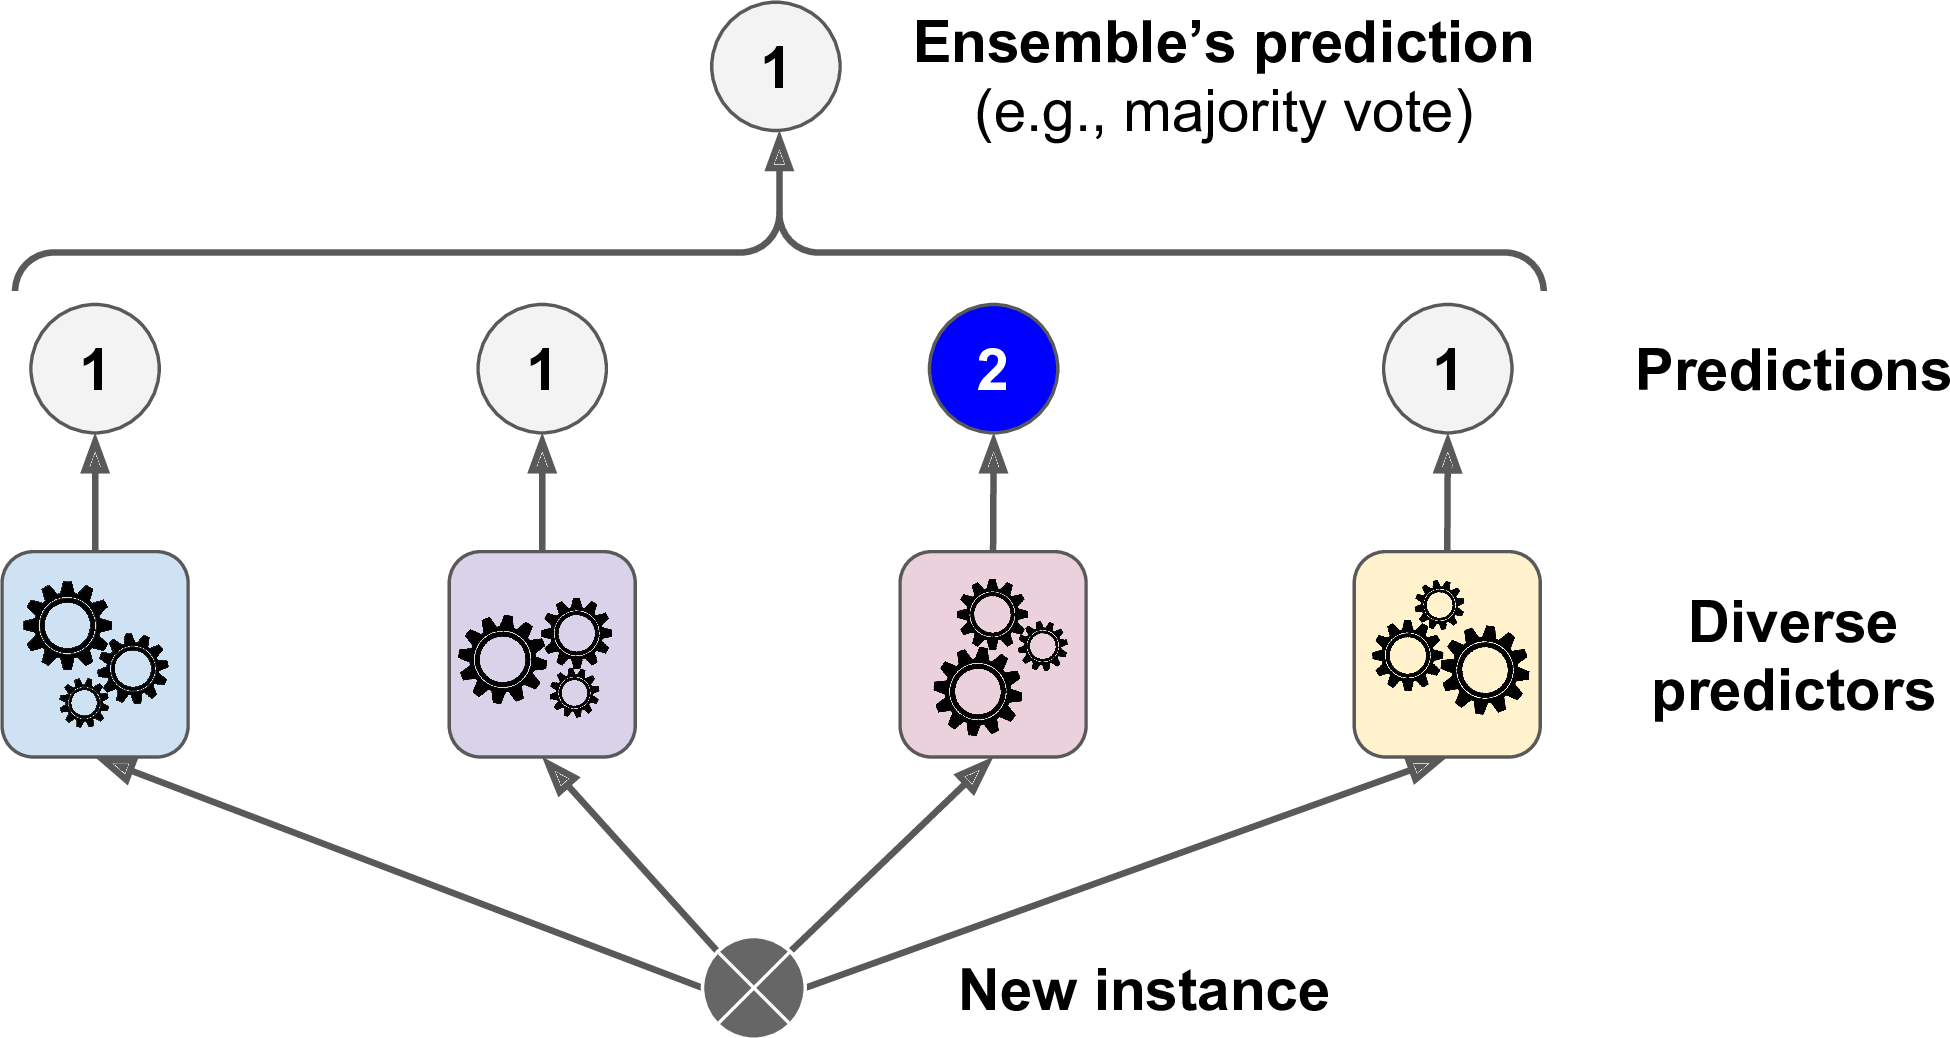
</p>
Figure 7-2. Hard voting classifier predictions

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), provided there are a sufficient number of weak learners and they are sufficiently diverse

How is this possible? The following analogy can help shed some light on this mystery

Suppose you have a slightly biased coin that has a 51% chance of coming up heads, and 49% chance of coming up tails. If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, and hence a majority of heads. If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%

The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%)

Figure 7-3 shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventu ally all 10 series end up so close to 51% that they are consistently above 50%

<p align='center'>
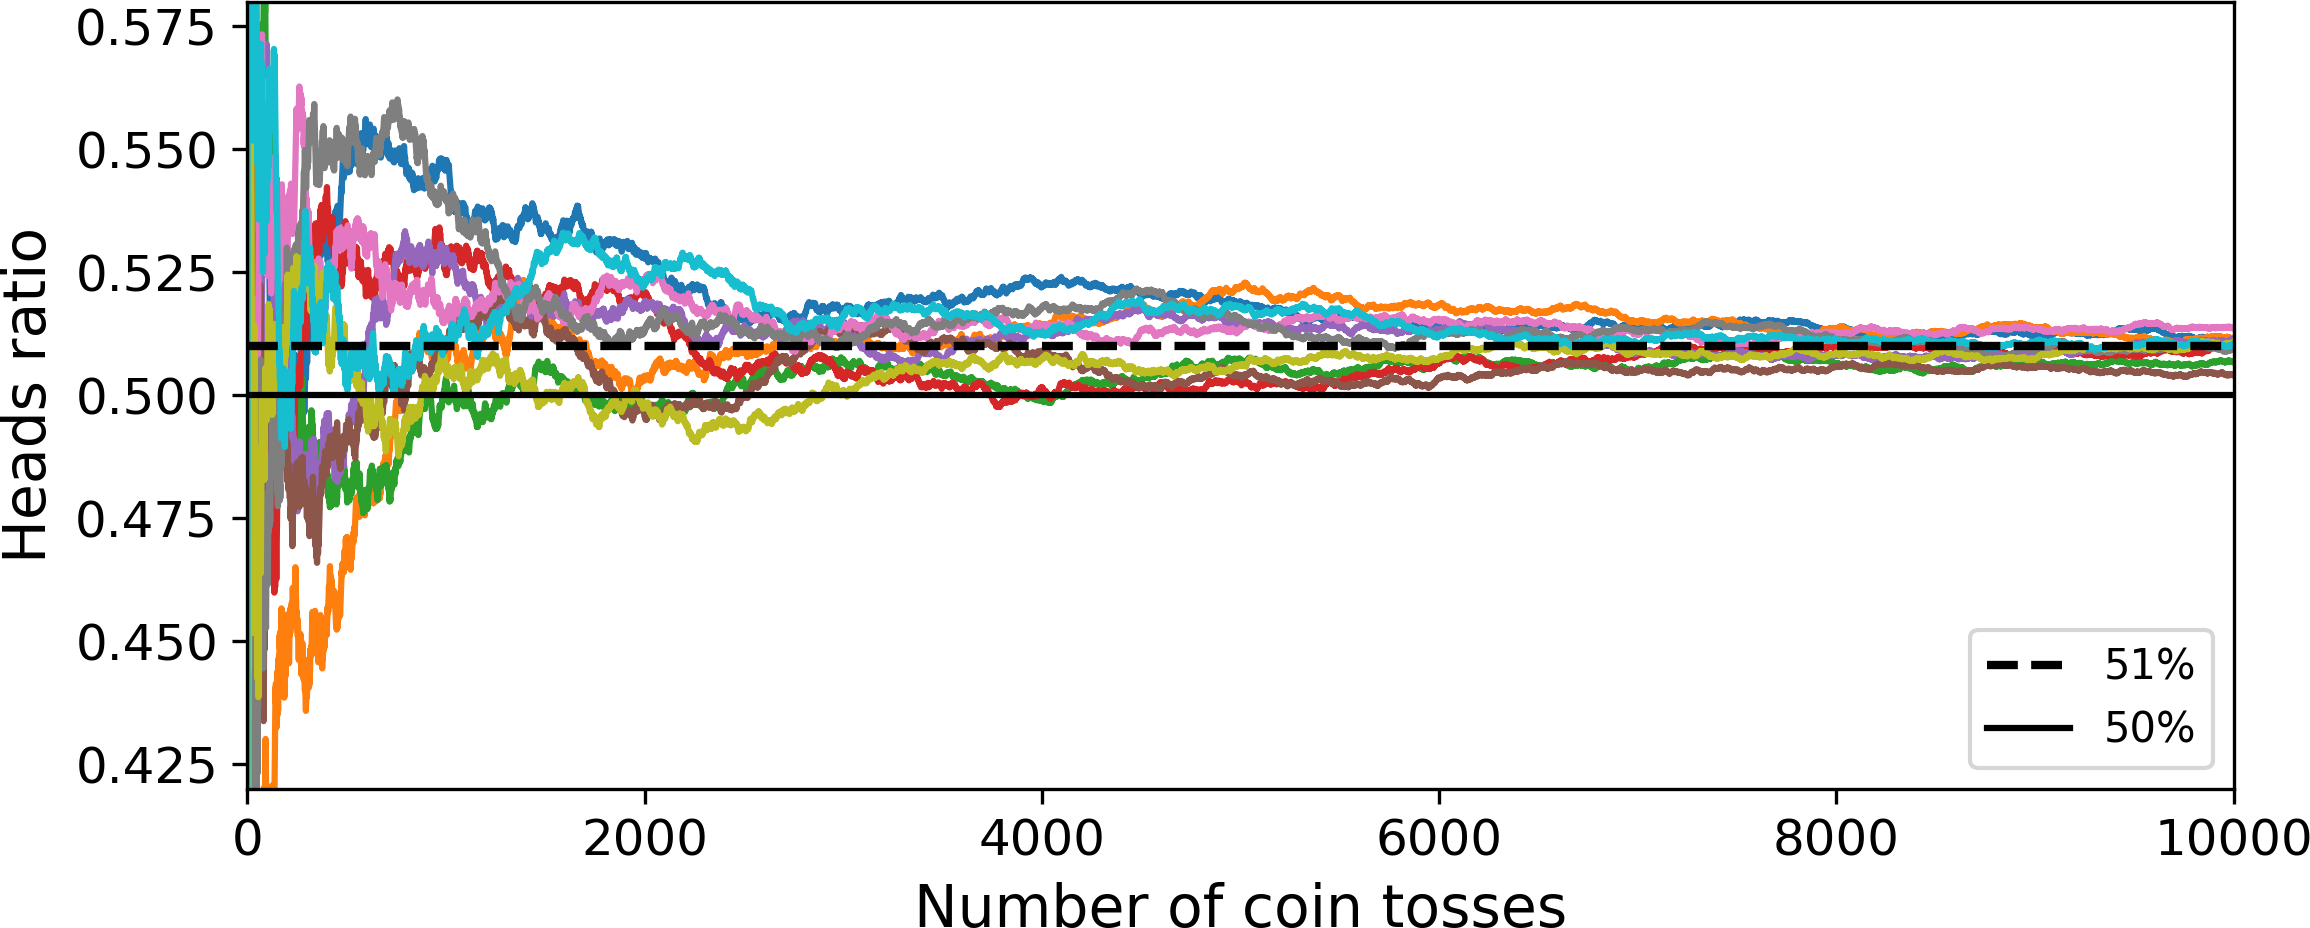
</p>
Figure 7-3. The law of large numbers

Similarly, suppose you build an ensemble containing 1,000 classifiers that are individually correct only 51% of the time (barely better than random guessing). If you predict the majority voted class, you can hope for up to 75% accuracy! However, this is only true if all classifiers are perfectly independent, making uncorrelated errors, which is clearly not the case since they are trained on the same data. They are likely to make the same types of errors, so there will be many majority votes for the wrong class, reducing the ensemble’s accuracy

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset, introduced in Chapter 5)

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

Let’s look at each classifier’s accuracy on the test set

In [43]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8
RandomForestClassifier 0.888
SVC 0.888
VotingClassifier 0.888


There you have it! The voting classifier slightly outperforms all the individual classifiers

If all classifiers are able to estimate class probabilities (i.e., they have a predict_proba() method), then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called sof voting. It often achieves higher performance than hard voting because it gives more weight to highly confident votes


All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities

This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method)

If you modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91.2% accuracy



# Bagging and Pasting


One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set

When sampling is performed with replacement, this method is called bagging (meaning that the individual data points can be chosen more than once) (short for bootstrap aggregating). When sampling is performed without replacement (each subset of the sample can be used once at most), it is called pasting

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor. This sampling and training process is represented in Figure 7-4

<p align='center'>
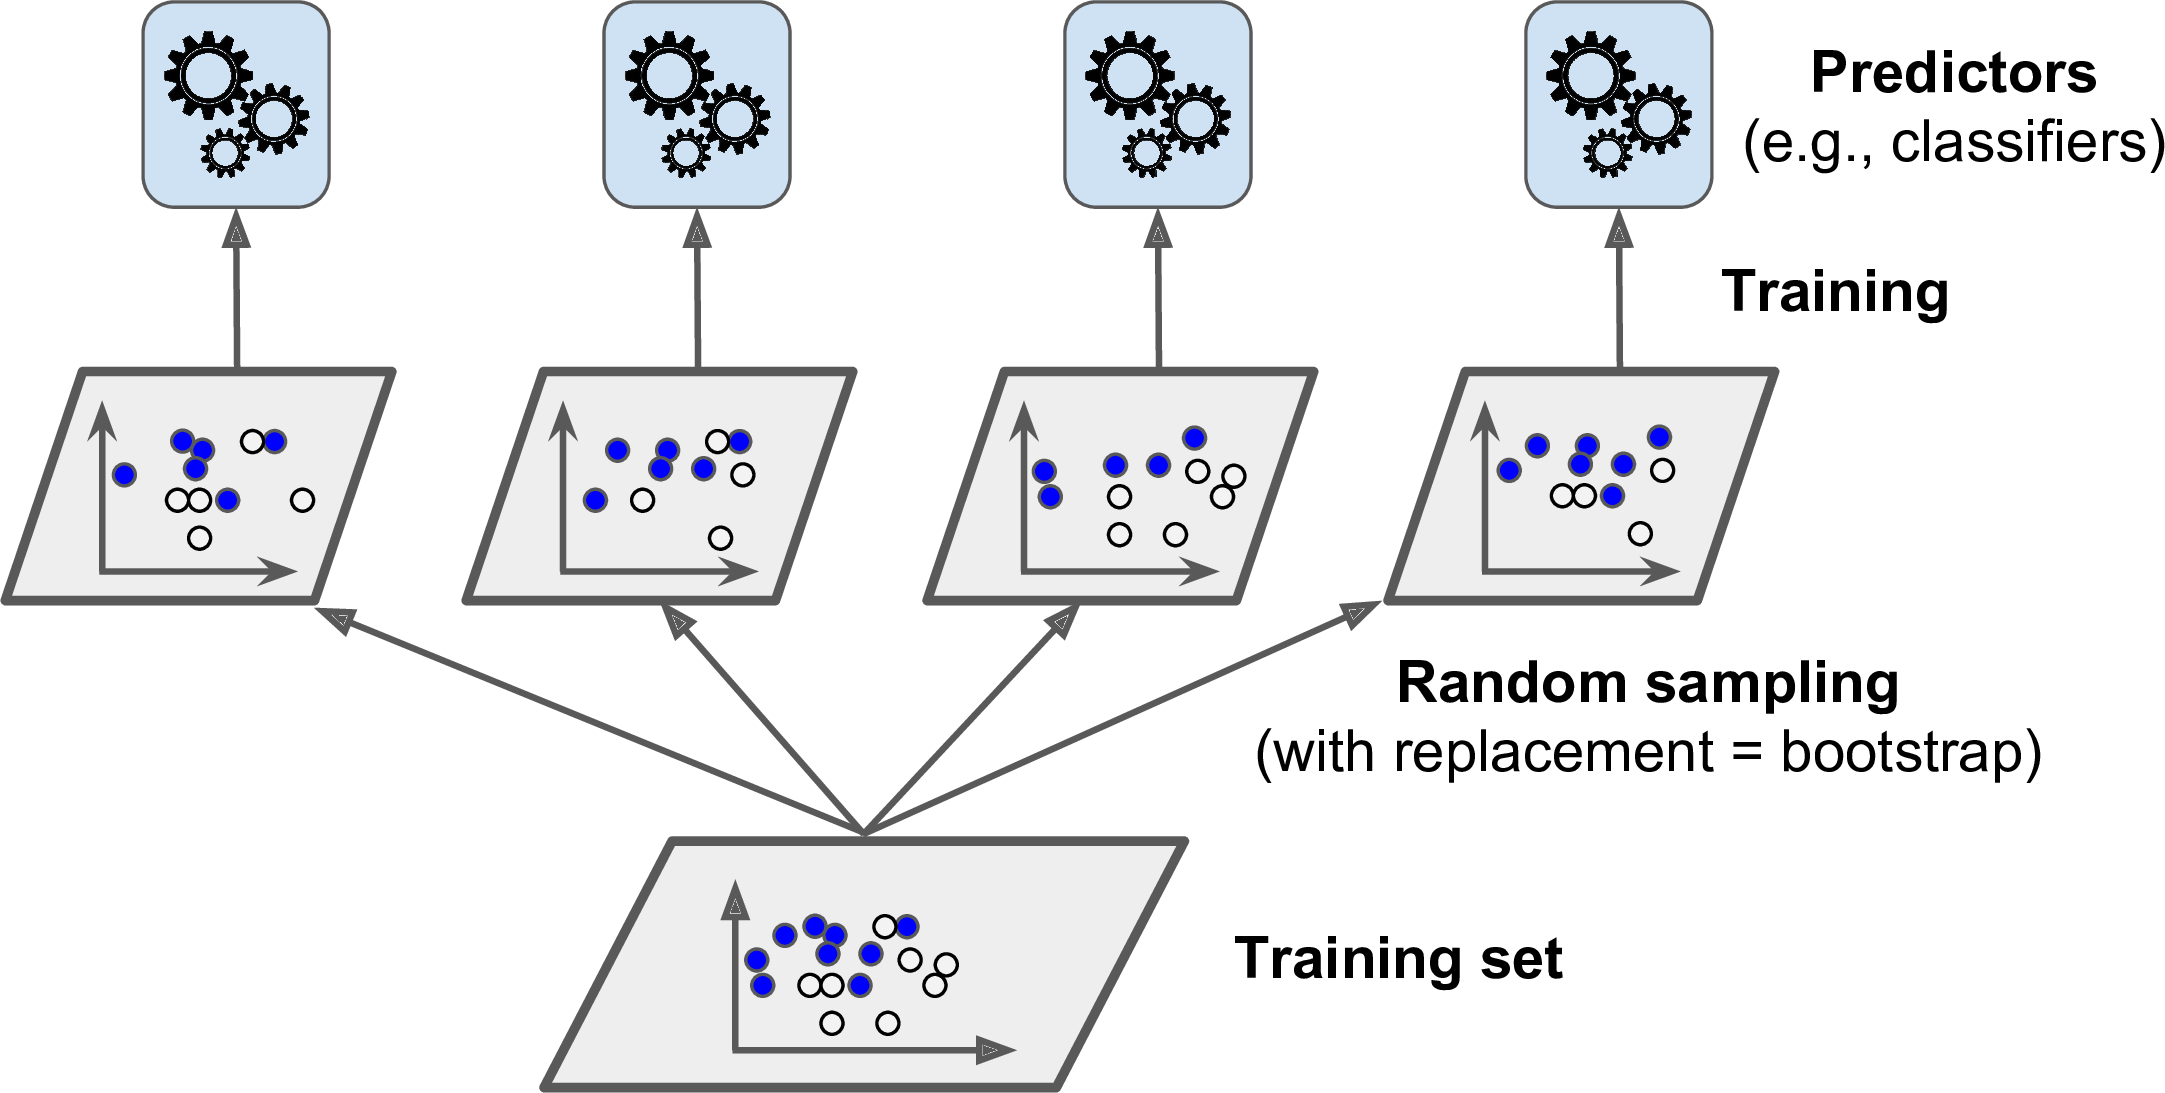
</p>
Figure 7-4. Pasting/bagging training set sampling and training

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors

The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set

As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well

# Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClassifier class (or BaggingRegressor for regression)

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False)

The n_jobs parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)

In [32]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.

Figure 7-5 compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular)

<p align='center'>
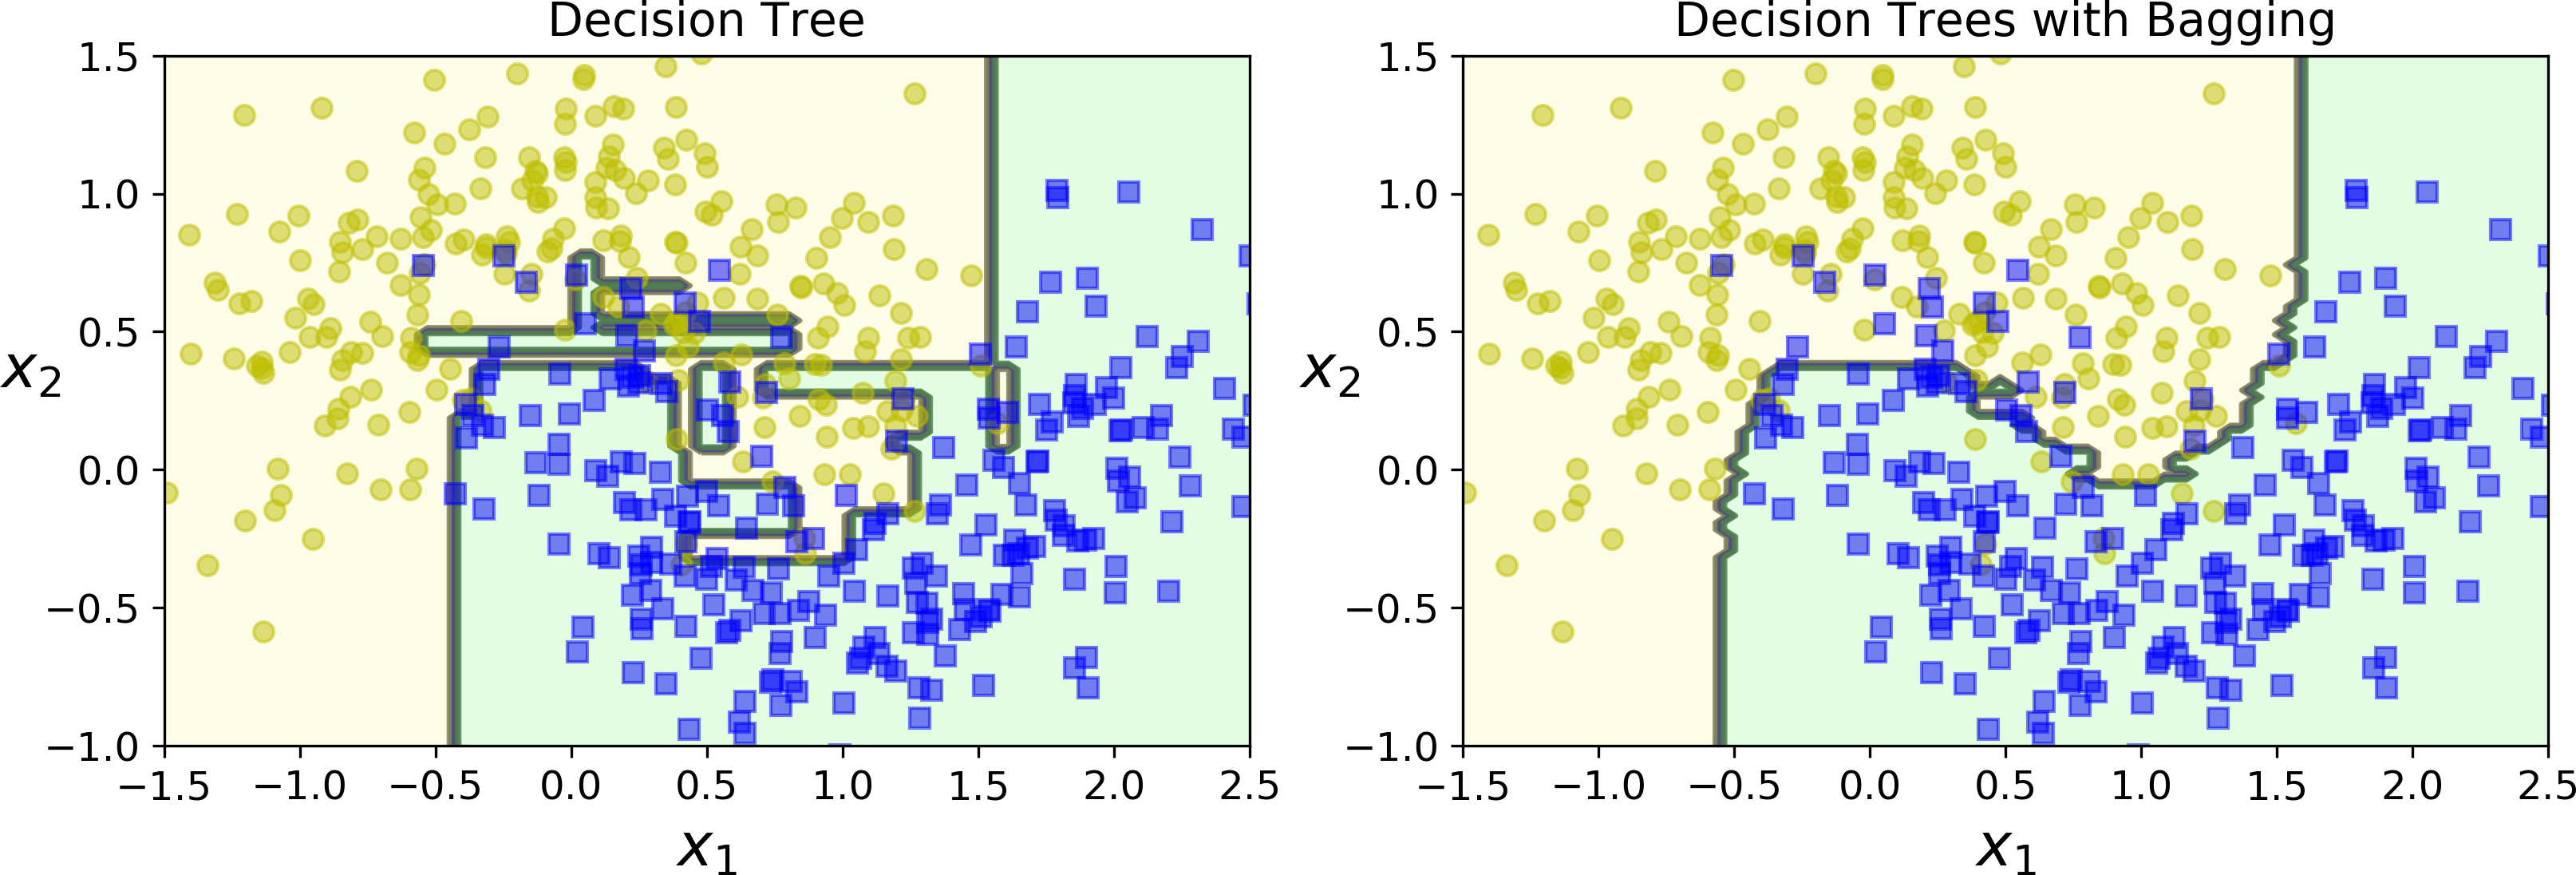
</p>
Figure 7-5. A single Decision Tree versus a bagging ensemble of 500 trees

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced

Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross validation to evaluate both bagging and pasting and select the one that works best

# Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default a BaggingClassifier samples m training instances with replacement  (bootstrap=True), where m is the size of the training set

This means that only about 63% of the training instances are sampled on average for each predictor. The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor



> As m grows, this ratio approaches $ 1 - exp(-1) \approx 63.212%$

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training

The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable

In [33]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [34]:
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, this is likely to achieve about BaggingClassifier 89.3% accuracy on the test set. Let’s verify this

In [35]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

We get 89.6% accuracy on the test set—close enough

The oob decision function for each training instance is also available through the oob_decision_function_ variable. In this case (since the base estimator has a predict_proba() method) the decision function returns the class probabilities for each training instance

For example, the oob evaluation estimates that the first training instance has a 68.25% probability of belonging to the positive class (and 31.75% of belonging to the negative class)

In [36]:
bag_clf.oob_decision_function_

array([[0.03680982, 0.96319018],
       [0.06024096, 0.93975904],
       [0.7979798 , 0.2020202 ],
       [1.        , 0.        ],
       [0.64210526, 0.35789474],
       [0.07567568, 0.92432432],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.53157895, 0.46842105],
       [0.03296703, 0.96703297],
       [0.93103448, 0.06896552],
       [0.98245614, 0.01754386],
       [0.25247525, 0.74752475],
       [0.57142857, 0.42857143],
       [0.        , 1.        ],
       [0.98941799, 0.01058201],
       [1.        , 0.        ],
       [0.99441341, 0.00558659],
       [0.79885057, 0.20114943],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.70053476, 0.29946524],
       [1.        , 0.        ],
       [0.00568182, 0.99431818],
       [0.06145251, 0.93854749],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.26203209, 0.73796791],
       [0.99459459, 0.00540541],
       [0.

# Random Patches and Random Subspaces

The BaggingClassifier class supports sampling the features as well. This is controlled by two hyperparameters: max_features and bootstrap_feautres. They work the same way as max_samples and bootstrap, but for feature sampling instead of instance sampling. Thus, each predictor will be trained on a random subset of the input features

This is particularly useful when you are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the Random Patches method

Keeping all training instances (i.e., bootstrap=False and max_samples=1.0) but sampling features (i.e., bootstrap_feautres=True and/or max_features smaller than 1.0) is called the Random Subspace method 

Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance

# Random Forests

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the RandomForestClassifier class, which is more convenient and optimized for Decision Trees (similarly, there is a RandomForestRegressor class for regression tasks) 



The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores

In [37]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the esemble itself

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features

This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model

The following is BaggingClassifier roughly equivalent to the previous RandomForestClassifier

In [38]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## Extra-Trees

When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting (as discussed earlier). It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do)

A forest of such extremely random trees is simply called an Extremely Randomized Trees ensemble (or Extra-Trees for short)

Once again, this trades more bias for a lower variance. It also makes Extra-Trees much faster to train than regular Random Forests since finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree

You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier class. Its API is identical to the RandomForestClassifier class

Similarly, the ExtraTreesRegressor class has the same API as the RandomForestRegressor class

> It is hard to tell in advance whether a RandomForestClassifier will perform better or worse than an ExtraTreesClassifier. Generally, the only way to know is to try both and compare them using cross-validation (and tuning the hyperparameters using grid search)

## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature

Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it

Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the feature_importances_ variable

For example, the following code trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and outputs each feature’s importance. It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unim portant in comparison (11% and 2%, respectively)


In [39]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10093469278782358
sepal width (cm) 0.02345918336029351
petal length (cm) 0.43742848210035284
petal width (cm) 0.4381776417515301


Similarly, if you train a Random Forest classifier on the MNIST dataset (introduced in Chapter 3) and plot each pixel’s importance, you get the image represented in Figure 7-6

In [40]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [44]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist['data'], mnist['target'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_digit(data):
  image = data.reshape(28, 28)
  plt.figure(figsize=(10, 8))
  plt.imshow(image, cmap = mpl.cm.hot,
              interpolation='nearest')
  plt.axis('off')

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

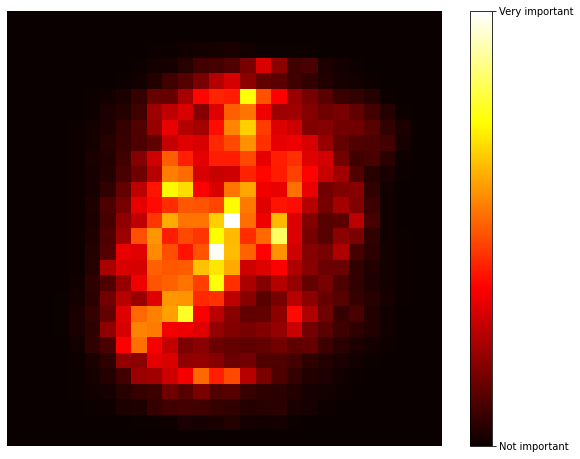

In [46]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

Figure 7-6. MNIST pixel importance (according to a Random Forest classifier

# Boosting

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner

The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor

There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting


## AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted

This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on (see Figure 7-7)

<p align='center'>

</p>

Figure 7-7. AdaBoost sequential training with instance weight updates

Figure 7-8 shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel)

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on

The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration)

As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’ parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better

<p align='center'>
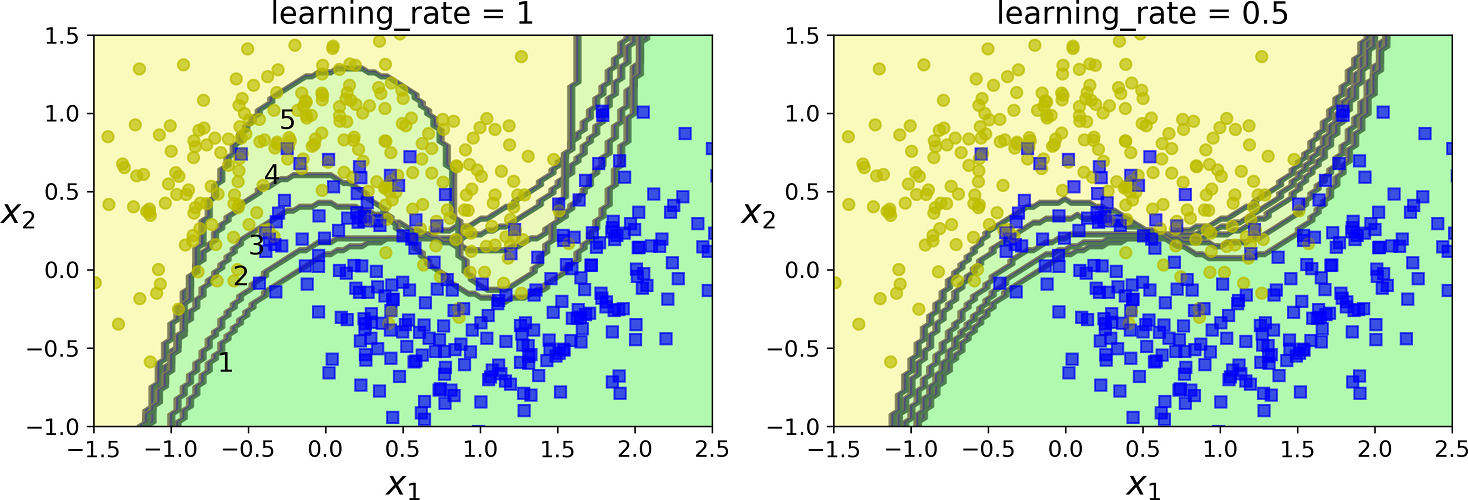
</p>
Figure 7-8. Decision boundaries of consecutive predictors

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set

> There is one important drawback to this sequential learning technique: it cannot be parallelized (or only partially), since each predictor can only be trained after the previous predictor has been trained and evaluated. As a result, it does not scale as well as bagging or pasting

Let’s take a closer look at the AdaBoost algorithm. Each instance weight $w^{(i)}$ set to is initially $\frac 1m$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set; see Equation 7-1

Equation 7-1. Weighted error rate of the $j^{th}$ predictor

$$ r_j = {{\underset {\hat y^{(i)}_j \neq y^{(i)}}{\sum^m_{i=1} {w^{(i)}}}} \over {\sum^m_{i = 1} w^{(i)}}} $$

where $\hat y^{(i)}_j$ is the $j^{th}$ predictor's prediction for the $i^{th}$ instance

The predictor’s weight $a_j$ is then computed using Equation 7-2, where $\eta$ is the learning rate hyperparameter (defaults to 1)

The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero

However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative


Equation 7-2. Predictor weight

$$ \alpha_j = \eta log \frac{1- r_j}{r_j} $$

Next the instance weights are updated using Equation 7-3: the misclassified instances are boosted

Equation 7-3. Weight update rule

$$ \text{for i} = 1,2,\dots,m \\ w^{(i)} \leftarrow \begin{cases} w^{(i)}\text{ if } \hat y_j^{(i)} = y^{(i)} \\ w^{(i)} exp (\alpha_j)  \text{ if } \hat y_j^{(i)} \neq y^{(i)} \end{cases} $$

Then all the instance weights are normalized (i.e., divided by $\sum^,_{i = 1} w^{(i)}$)

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $\alpha_j$ 

The predicted class is the one that receives the majority of weighted votes (see Equation 7-4)

Equation 7-4. AdaBoost predictions

$$ \hat y (x) = \underset {k} {\text{argmax}} \underset {\hat y_j (x) = k} {\sum_{j = 1}^N} a_j \text{ where N is the number of predictors} $$

Scikit-Learn actually uses a multiclass version of AdaBoost called SAMME (which stands for Stagewise Additive Modeling using a Multiclass Exponential loss function)

When there are just two classes, SAMME is equivalent to AdaBoost. Moreover, if the
predictors can estimate class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class probabilities rather than predictions and generally performs better

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an AdaBoostRegressor class)

A Decision Stump is a Decision Tree with max_depth=1 —in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the AdaBoostClassifier class:

In [47]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

> If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator

## Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor

However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT)

First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [69]:
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now train a second DecisionTreeRegressor on the residual errors made by the first predictor

In [70]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor

In [71]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees

In [75]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

Figure 7-9 represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree

On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble

<p align='center'>

</p>
Figure 7-9. Gradient Boosting

A simpler way to train GBRT ensembles is to use Scikit-Learn’s GradientBoostingRegressor class. Much like the RandomForestRegressor class, it has hyperparameters to control the growth of Decision Trees (e.g., max_depth, min_samples_leaf, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (n_estimators)

The following code creates the same ensemble as the previous one:

In [76]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The learning_rate hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization tech nique called shrinkage.

Figure 7-10 shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set



<p align='center'>

</p>
Figure 7-10. GBRT ensembles with not enough predictors (left) and too many (right)

In order to find the optimal number of trees, you can use early stopping. A simple way to implement this is to use the staged_predict() method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.)

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=84,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The validation errors are represented on the left of Figure 7-11, and the best model’ predictions are represented on the right

<p align='center'>
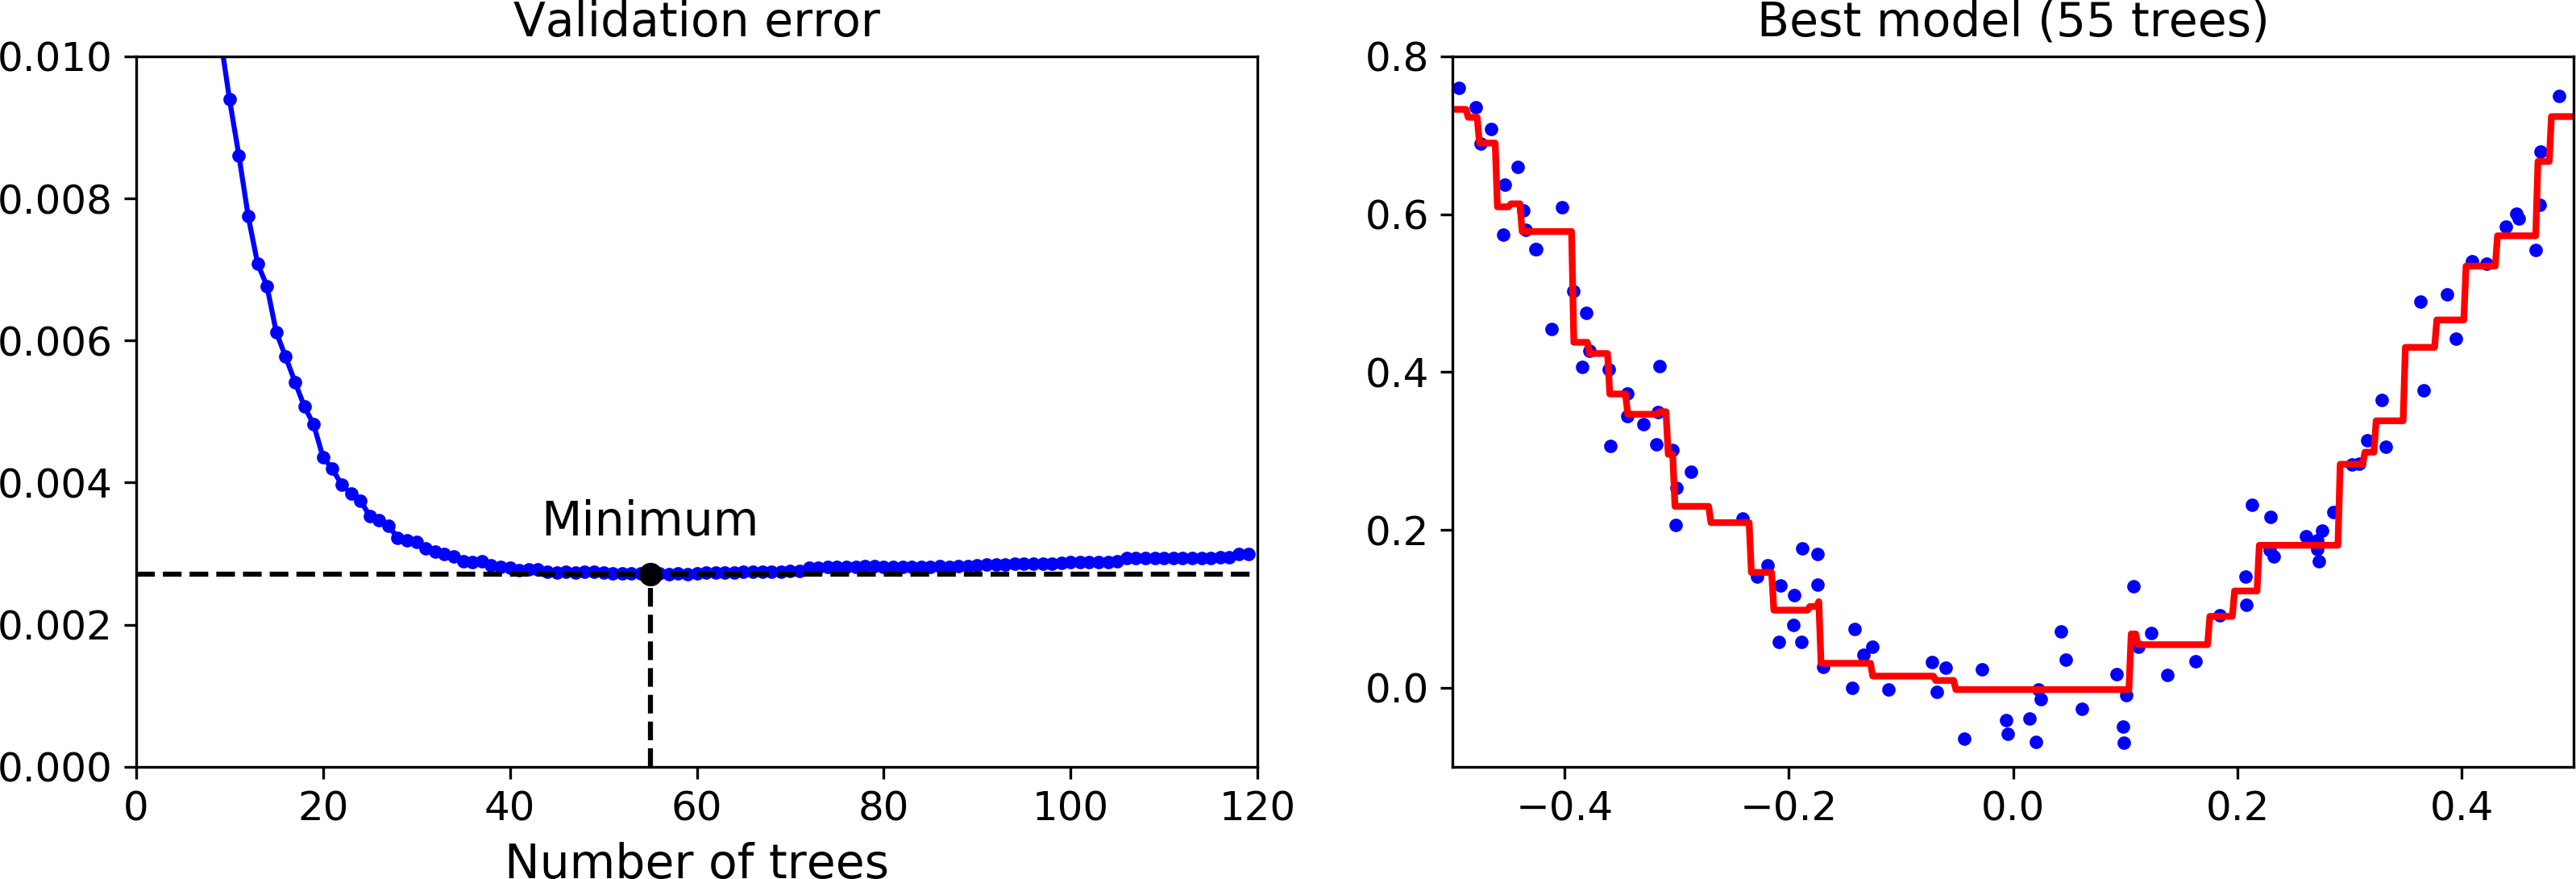
</p>
Figure 7-11. Tuning the number of trees using early stopping

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). 

You can do so by setting warm_start=True, which makes Scikit-Learn keep existing trees when the fit() method is called, allowing incremental training

The following code stops training when the validation error does not improve for five iterations in a row:


In [79]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 20):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # early stopping

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree

For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly 

As you can probably guess by now, this trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called Stochastic Gradient Boosting

It is worth noting that an optimized implementation of Gradient Boosting is available in the popular python library XGBoost, which stands for Extreme Gradient Boosting

This package was initially developed by Tianqi Chen as part of the Distributed (Deep) Machine Learning Community (DMLC), and it aims at being extremely fast, scalable and portable. In fact, XGBoost is often an important component of the winning entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [83]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[14:24:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBoost also offers several nice features, such as automatically taking care of early stopping

In [84]:
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[14:26:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.275313
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.247499
[2]	validation_0-rmse:0.222947
[3]	validation_0-rmse:0.201049
[4]	validation_0-rmse:0.181641
[5]	validation_0-rmse:0.166735
[6]	validation_0-rmse:0.153621
[7]	validation_0-rmse:0.141686
[8]	validation_0-rmse:0.131314
[9]	validation_0-rmse:0.122047
[10]	validation_0-rmse:0.112234
[11]	validation_0-rmse:0.10366
[12]	validation_0-rmse:0.097232
[13]	validation_0-rmse:0.092018
[14]	validation_0-rmse:0.087123
[15]	validation_0-rmse:0.083105
[16]	validation_0-rmse:0.079681
[17]	validation_0-rmse:0.076621
[18]	validation_0-rmse:0.074141
[19]	validation_0-rmse:0.071896
[20]	validation_0-rmse:0.070115
[21]	validation_0-rmse:0.068281
[22]	validation_0-rmse:0.066894
[23]	validation_0-rmse:0.065783
[24]	validation_0-rmse:0.064704
[25]	validation_0-rm

# Stacking

The last Ensemble method we will discuss in this chapter is called stacking (short for stacked generalization)

It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, why don’t we train a model to perform this aggregation?

Figure 7-12 shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0)

<p align='center'>
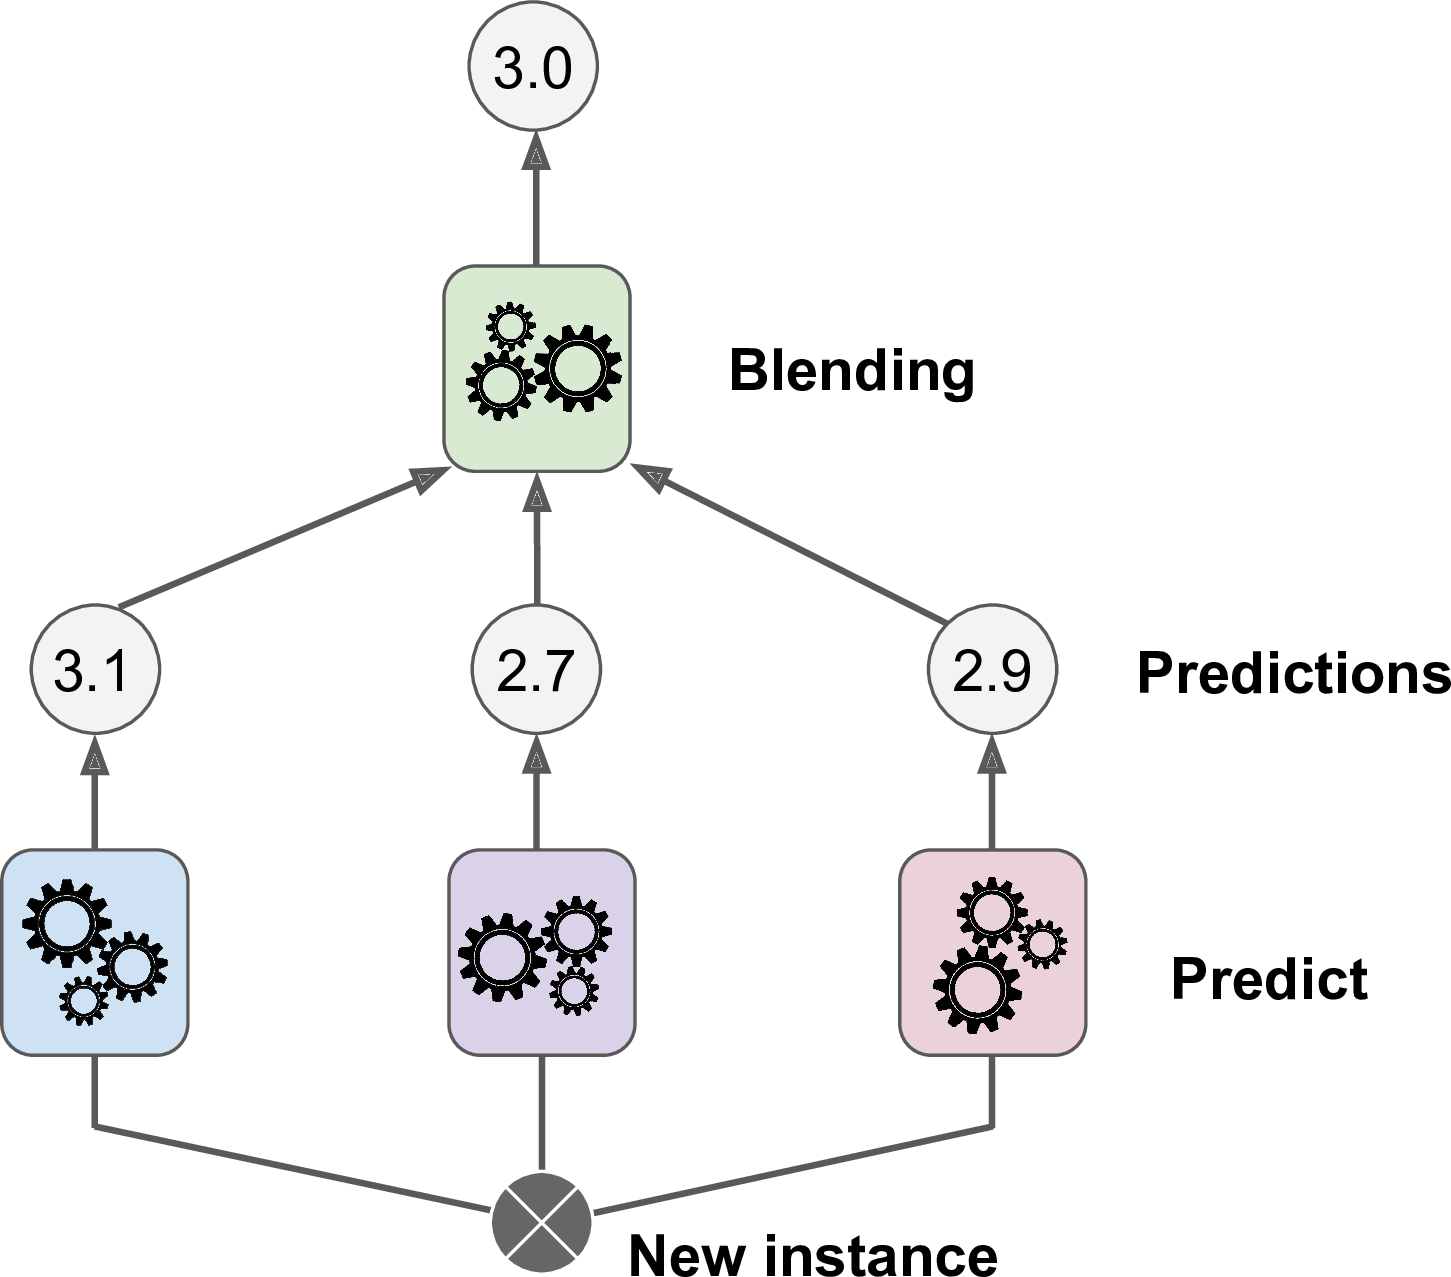
</p>
Figure 7-12. Aggregating predictions using a blending predictor

To train the blender, a common approach is to use a hold-out set. Let’s see how it works. First, the training set is split in two subsets. The first subset is used to train the predictors in the first layer (see Figure 7-13)

<p align='center'>

</p>
Figure 7-13. Training the first layer

Next, the first layer predictors are used to make predictions on the second (held-out) set (see Figure 7-14). This ensures that the predictions are “clean,” since the predictors never saw these instances during training

Now for each instance in the hold-out set there are three predicted values. We can create a new training set using these predicted values as input features (which makes this new training set three-dimensional), and keeping the target values

The blender is trained on this new training set, so it learns to predict the target value given the first layer’s predictions



<p align='center'>

</p>
Figure 7-14. Training the blender

It is actually possible to train several different blenders this way (e.g., one using Lin ear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders

The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using pre dictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in Figure 7-15

<p align='center'>

</p>
Figure 7-15. Predictions in a multilayer stacking ensemble

Unfortunately, Scikit-Learn does not support stacking directly

Alternatively, you can use an open source implementation such as (available at https://github.com/ brew viisar/brew)
